In [1]:
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import requests
import lxml
from lxml.html.soupparser import fromstring
import prettify
import numbers
import htmltext
import json
import geopy.distance
from datetime import date
import sqlite3
pd.options.mode.chained_assignment = None  # default='warn'

In [42]:
def scraper(url):
    req_headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.8',
        'upgrade-insecure-requests': '1',
        'user-agent': 'charlesbarry8895@gmail.com'
    }
    
    with requests.Session() as s:
       response = s.get(url, headers=req_headers)
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    list1 = str(soup.find_all('script', {'type': 'application/json'}))[str(soup.find_all('script', {'type': 'application/json'})).find('zpid')-1:].split(",")
    list2 = [i.replace('"', '').split(":") for i in list1]
    
    detailUrl = [i[2].replace('//', '') for i in list2 if i[0] == 'detailUrl']
    unformattedPrice = [i[1] for i in list2 if i[0] == 'unformattedPrice']
    address = [i[1] for i in list2 if i[0] == 'address']
    addressStreet = [i[1] for i in list2 if i[0] == 'addressStreet']
    addressCity = [i[1] for i in list2 if i[0] == 'addressCity']
    addressZipcode = [i[1] for i in list2 if i[0] == 'addressZipcode']
    addressState = [i[1] for i in list2 if i[0] == 'addressState']
    beds = [i[1] for i in list2 if i[0] == 'beds']
    baths = [i[1] for i in list2 if i[0] == 'baths']
    area = [i[1] for i in list2 if i[0] == 'area']
    latitude = [i[1] for i in list2 if i[0] == 'latitude']
    latitude = [latitude[i] for i in range(len(latitude)) if '}' not in str(latitude[i])]
    longitude = [i[1] for i in list2 if i[0] == 'longitude']
    longitude = [longitude[i] for i in range(len(longitude)) if '}' not in str(longitude[i])]
    bathrooms = [i[1] for i in list2 if i[0] == 'bathrooms']
    bedrooms = [i[1] for i in list2 if i[0] == 'bedrooms']
    livingArea = [i[1] for i in list2 if i[0] == 'livingArea']
    homeType = [i[1] for i in list2 if i[0] == 'homeType']
    daysOnZillow = [i[1] for i in list2 if i[0] == 'daysOnZillow']
    zestimate = [i[1] for i in list2 if i[0] == 'zestimate']
    rentZestimate = [i[1] for i in list2 if i[0] == 'rentZestimate']
    isPreforeclosureAuction = [i[1] for i in list2 if i[0] == 'isPreforeclosureAuctio']
    priceForHDP = [i[1] for i in list2 if i[0] == 'priceForHDP']
    taxAssessedValue = [i[1] for i in list2 if i[0] == 'taxAssessedValue']
    lotAreaValue = [i[1] for i in list2 if i[0] == 'lotAreaValue']
    lotAreaUnit = [i[1] for i in list2 if i[0] == 'lotAreaUnit']
    
    print(f'{len(longitude)} Records found at {url}')
    
    ### - Array Length Checks
    bool_value = (len(detailUrl) == len(unformattedPrice) == len(address) == len(addressStreet) ==
                  len(addressCity) == len(addressZipcode) == len(addressState) == len(beds) ==
                  len(baths) == len(area) == len(latitude) == len(longitude))
    
    if bool_value:
        df = pd.DataFrame({'detailUrl':detailUrl,
                           'unformattedPrice':unformattedPrice, 'address':address, 'addressStreet':addressStreet,
                           'addressCity':addressCity, 'addressZipcode':addressZipcode, 'addressState':addressState,
                           'beds':beds, 'baths':baths, 
                           'area':area, 
                           'latitude':latitude, 'longitude':longitude
    #                        'rentZestimate':rentZestimate, 'zestimate':zestimate
                          })

        return df
    else:
        print(f'Improper Array Lengths for {url}')

In [26]:
(len([0,1]) == len([0,1]) == len([1,2,3]))

False

In [33]:
os.chdir('C:\\Users\\cbarry\\Documents\\03000. Professional Development\\denver_real_estate\\source_data')

In [43]:
def spider(url_list, pois):
    
    ### - Build Out initial dataframe via web-scraping small geographical blocks
    i=0
    for url in url_list:
        if i==0:
            df = scraper(url)
        else:
            df = pd.concat([df, scraper(url)])
        print(f'Scraped url # {i}')
        i=i+1
    
    ### - Read in Reference Data
    os.chdir('C:\\Users\\cbarry\\Documents\\03000. Professional Development\\denver_real_estate\\source_data')
    edu_scores = pd.read_csv("Education_Scores_Colorado.csv").groupby('County').mean().reset_index()[['County', 'Rank score (2022)']].rename({'Rank score (2022)':'edu_rank_score_2022'}, axis=1)
    co_zips = pd.read_csv('colorado_zip_codes.csv')[['zip', 'county']]
    property_characteristics = pd.read_csv('real_property_residential_characteristics.csv')
    os.chdir('C:\\Users\\cbarry\\Documents\\03000. Professional Development\\denver_real_estate\\ETL')
    
    prop_char = property_characteristics.groupby('OWNER_CITY').agg({'TOTAL_VALUE': 'mean'}).reset_index()
    
    ### - DataFrame Standardization
    df.addressZipcode = df.addressZipcode.astype(int)
    property_characteristics.OWNER_CITY = property_characteristics.OWNER_CITY.str.upper()
    df.addressCity = df.addressCity.str.upper()
    df['dist_to_downtown'] = np.nan
    df['dist_to_ski'] = np.nan
    df['dist_to_red_rocks'] = np.nan
    
    ### - Merge with Reference Data
    edu_final = pd.merge(co_zips, edu_scores, how='left', left_on='county', right_on='County')[['zip', 'county', 'edu_rank_score_2022']].drop_duplicates()
    edu_final.zip = edu_final.zip.astype(int)
    df = pd.merge(df, edu_final, how='left', left_on='addressZipcode', right_on = 'zip')
    df = pd.merge(df, prop_char, how='left', left_on='addressCity', right_on = 'OWNER_CITY').rename({'TOTAL_VALUE':'average_home_value'}, axis=1)
    
    ### - Distance Calculations
    for i in range(len(df.beds)):
        coords_downtown = (float(pois['RiNo (River North Arts District)'][0]), float(pois['RiNo (River North Arts District)'][1]))
        coords_ski = (float(pois['Breckenridge Ski Resort'][0]), float(pois['Breckenridge Ski Resort'][1]))
        coords_redrocks = (float(pois['Red Rocks Park & Ampitheatre'][0]), float(pois['Red Rocks Park & Ampitheatre'][1]))
        coords_2 = (float(df.latitude[i]), float(df.longitude[i]))

        df['dist_to_downtown'][i] = geopy.distance.geodesic(coords_downtown, coords_2).miles
        df['dist_to_ski'][i] = geopy.distance.geodesic(coords_ski, coords_2).miles
        df['dist_to_red_rocks'][i] = geopy.distance.geodesic(coords_redrocks, coords_2).miles
        
    ### - Date Stamp
    df['date_stamp'] = str(date.today())
    
    os.chdir('C:\\Users\\cbarry\\Documents\\03000. Professional Development\\denver_real_estate')
    cursor = sqlite3.connect("denver_real_estate.db")
    
    df2 = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
    ''', cursor).drop(columns=['index'])
    
    j=0
    for i in range(len(df.beds)):
        if df.address[i] not in set(df2.address):
            df2 = pd.concat([df2, df.iloc[[i]][df2.columns]])
            j=j+1
            
    if j!=0:
        print(f'{j} New Records added to denver_active_listings database')
        df2.to_sql("denver_active_listings", cursor, if_exists="replace")
    else:
        print('No new records Added.')
        
    cursor.close()
    
    return df2

In [44]:
url_list = [
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.09244434667967%2C%22east%22%3A-104.99210827185057%2C%22south%22%3A39.82192558361923%2C%22north%22%3A39.87688193008983%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%2C%22customRegionId%22%3A%224921263332X1-CRc5jwsg5urqf2_vpzyi%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.17088775348857%2C%22east%22%3A-105.07055167865947%2C%22south%22%3A39.76485746705134%2C%22north%22%3A39.819859453994965%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%2C%22customRegionId%22%3A%224921663332X1-CRc5jwsg5ukcxq_vpzyi%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.17088775348857%2C%22east%22%3A-105.07055167865947%2C%22south%22%3A39.76485746705134%2C%22north%22%3A39.819859453994965%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%2C%22customRegionId%22%3A%224921763332X1-CRc5iiwi948qke_vpzyi%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.23646239948467%2C%22east%22%3A-105.03579024982646%2C%22south%22%3A39.5974363612821%2C%22north%22%3A39.70766355796882%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22b1c1363332X1-CR1cng3vv3bt0u6_12e779%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.24178390217021%2C%22east%22%3A-105.04111175251201%2C%22south%22%3A39.5540805935407%2C%22north%22%3A39.66437683458322%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22b1c1563332X1-CR1cng3vv3bky2m_12e779%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.24178390217021%2C%22east%22%3A-105.04111175251201%2C%22south%22%3A39.5540805935407%2C%22north%22%3A39.66437683458322%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22b1c1763332X1-CR1cnhhrt02j1j2_12e779%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.20583703400624%2C%22east%22%3A-105.00516488434803%2C%22south%22%3A39.6038985156616%2C%22north%22%3A39.714115415930586%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22b1c1a63332X1-CR1cng3vv3aww3i_12e779%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.20583703400624%2C%22east%22%3A-105.00516488434803%2C%22south%22%3A39.6038985156616%2C%22north%22%3A39.714115415930586%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22b1c1b63332X1-CR1cnhhrt01pmri_12e779%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.20583703400624%2C%22east%22%3A-105.00516488434803%2C%22south%22%3A39.6038985156616%2C%22north%22%3A39.714115415930586%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22b1c1c63332X1-CR1cnhhrt01i64e_12e779%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.18197610260975%2C%22east%22%3A-104.98130395295155%2C%22south%22%3A39.63708779747628%2C%22north%22%3A39.747251793854325%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22dfb5c63332X1-CRemwcplhx5ldq_112fv7%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.18197610260975%2C%22east%22%3A-104.98130395295155%2C%22south%22%3A39.63708779747628%2C%22north%22%3A39.747251793854325%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%2C%22customRegionId%22%3A%22dfb5d63332X1-CRemxqljenyc1q_112fv7%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.41987743017576%2C%22east%22%3A-104.61718883154295%2C%22south%22%3A39.49850190014897%2C%22north%22%3A39.93898578651931%7D%2C%22mapZoom%22%3A11%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%22087646333aX1-CRmmtr3w5xr6v2_x5yzz%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.41987743017576%2C%22east%22%3A-104.61718883154295%2C%22south%22%3A39.49850190014897%2C%22north%22%3A39.93898578651931%7D%2C%22mapZoom%22%3A11%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%22087686333aX1-CRmmtr3w5y9pq6_x5yzz%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.44253673193357%2C%22east%22%3A-104.63984813330076%2C%22south%22%3A39.5228704496253%2C%22north%22%3A39.963199152646%7D%2C%22mapZoom%22%3A11%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%220876a6333aX1-CRmmtr3w5y0xoe_x5yzz%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.44253673193357%2C%22east%22%3A-104.63984813330076%2C%22south%22%3A39.5228704496253%2C%22north%22%3A39.963199152646%7D%2C%22mapZoom%22%3A11%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%220876c6333aX1-CRmmtr3w5y43ge_x5yzz%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.25010432836912%2C%22east%22%3A-104.84876002905271%2C%22south%22%3A39.57541912527453%2C%22north%22%3A39.79576786384407%7D%2C%22mapZoom%22%3A12%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%22087726333aX1-CRmmv4zu2o4nlq_x5yzz%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.22658671972654%2C%22east%22%3A-104.82524242041013%2C%22south%22%3A39.62581253909955%2C%22north%22%3A39.84600063236045%7D%2C%22mapZoom%22%3A12%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%22087776333aX1-CRmmtr3w5xk60u_x5yzz%22%7D',
    'https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.09397830603025%2C%22east%22%3A-104.89330615637205%2C%22south%22%3A39.681123668314655%2C%22north%22%3A39.79121741436106%7D%2C%22mapZoom%22%3A13%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22customRegionId%22%3A%22087796333aX1-CRmmv4zu2ofzb2_x5yzz%22%7D'
]

pois = {
    'RiNo (River North Arts District)': [39.7678828, -104.978807],
    'Breckenridge Ski Resort': [39.4775381, -106.1135842],
    'Red Rocks Park & Ampitheatre': [39.6655381, -105.2074003]
}

In [45]:
df = spider(url_list, pois)

33 Records found at https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Westminster%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.09244434667967%2C%22east%22%3A-104.99210827185057%2C%22south%22%3A39.82192558361923%2C%22north%22%3A39.87688193008983%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%2C%22customRegionId%22%3A%224921263332X1-CRc5jwsg5urqf2_vpzyi%22%7D
Scraped url # 0
30 Records found at https://www.zillow.com/homes/for_sale/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Denver%2C%20CO%22%2C%22mapBounds%22%3A%7B%22west%22%3A-105.17088775348857%2C%22east%22%3A-105.07055167865947%2C%22south%22%3A39.76485746705134%2C%22north%22%3A39.819859453994965%7D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22

In [ ]:
df

unformattedPrice + (float)
beds + (int)
baths + (int)
area + (float)
addressCity + (cat)
dist_to_downtown + (float) 
dist_to_ski + (float)
dist_to_red_rocks + (float)
edu_rank_score_2022 + (float)
average_home_value + (float)

In [2]:
cursor = sqlite3.connect("denver_real_estate.db")
test = pd.read_sql_query(
    f'''
        SELECT *
        FROM test_df
    ''', cursor)

test.unformattedPrice = test.unformattedPrice.astype(float)
test.beds = test.beds.replace('null', 0).astype(int)
test.baths = test.baths.replace('null', 0).astype(float).astype(int)
test.area = test.area.replace('null', 0).astype(float)
test.addressCity = test.addressCity.astype("category")
test.dist_to_downtown = test.dist_to_downtown.astype(float)
test.dist_to_ski = test.dist_to_ski.astype(float)
test.dist_to_red_rocks = test.dist_to_red_rocks.astype(float)
test.edu_rank_score_2022 = test.edu_rank_score_2022.astype(float)
test.average_home_value = test.average_home_value.astype(float)

y = test.rank_score
x = test[['unformattedPrice', 'beds', 'area', 'addressCity',
         'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
         'edu_rank_score_2022', 'average_home_value']]

In [ ]:
def build_model():
    #Pull Test Data
    cursor = sqlite3.connect("denver_real_estate.db")
    test = pd.read_sql_query(
        f'''
            SELECT *
            FROM test_df
        ''', cursor)
    cursor.close()
    
    #Format data for model
    test.unformattedPrice = test.unformattedPrice.astype(float)
    test.beds = test.beds.replace('null', 0).astype(int)
    test.baths = test.baths.replace('null', 0).astype(float).astype(int)
    test.area = test.area.replace('null', 0).astype(float)
    test.addressCity = test.addressCity.astype("category")
    test.dist_to_downtown = test.dist_to_downtown.astype(float)
    test.dist_to_ski = test.dist_to_ski.astype(float)
    test.dist_to_red_rocks = test.dist_to_red_rocks.astype(float)
    test.edu_rank_score_2022 = test.edu_rank_score_2022.astype(float)
    test.average_home_value = test.average_home_value.astype(float)

    x = test[['unformattedPrice', 'beds', 'area', 'addressCity',
             'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
             'edu_rank_score_2022', 'average_home_value']]
    x = pd.get_dummies(x)
    
    y = test.rank_score
    
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
    # Train the model on training data
    rf.fit(x.fillna(0), y.fillna(0));
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(x.fillna(0))
    # Calculate the absolute errors
    errors = abs(predictions - y)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    cols=list(x.columns)
    
    return rf, cols

def score_data(rf, cols):
    cursor = sqlite3.connect("denver_real_estate.db")
    df = pd.read_sql_query(
        f'''
            SELECT *
            FROM denver_active_listings
            WHERE address NOT IN (SELECT address FROM denver_prediction_values)
        ''', cursor)
    
    if(set(df.address) == set(pred_df.address)):
        print('No new ')
    df.unformattedPrice = df.unformattedPrice.astype(float)
    df.beds = df.beds.replace('null', 0).astype(int)
    df.baths = df.baths.replace('null', 0).astype(float).astype(int)
    df.area = df.area.replace('null', 0).astype(float)
    df.addressCity = df.addressCity.astype("category")
    df.dist_to_downtown = df.dist_to_downtown.astype(float)
    df.dist_to_ski = df.dist_to_ski.astype(float)
    df.dist_to_red_rocks = df.dist_to_red_rocks.astype(float)
    df.edu_rank_score_2022 = df.edu_rank_score_2022.astype(float)
    df.average_home_value = df.average_home_value.astype(float)

    # y = df.rank_score
    x = df[['unformattedPrice', 'beds', 'area', 'addressCity',
             'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
             'edu_rank_score_2022', 'average_home_value']]
    x = pd.get_dummies(x)
    
    for col in cols:
        if col not in set(list(x.columns)):
            x[col] = 0
            
    x = x[cols].fillna(0)
    
    df['predictions'] = rf.predict(x)
    
    df = df[['address', 'predictions']]
    
    df.to_sql("denver_prediction_values", cursor, if_exists="append")
    cursor.close()

In [74]:
test = pd.read_sql_query(
    f'''
        SELECT *
        FROM test_df
    ''', cursor)
cursor.close()

#Format data for model
test.unformattedPrice = test.unformattedPrice.astype(float)
test.beds = test.beds.replace('null', 0).astype(int)
test.baths = test.baths.replace('null', 0).astype(float).astype(int)
test.area = test.area.replace('null', 0).astype(float)
test.addressCity = test.addressCity.astype("category")
test.dist_to_downtown = test.dist_to_downtown.astype(float)
test.dist_to_ski = test.dist_to_ski.astype(float)
test.dist_to_red_rocks = test.dist_to_red_rocks.astype(float)
test.edu_rank_score_2022 = test.edu_rank_score_2022.astype(float)
test.average_home_value = test.average_home_value.astype(float)

x = test[['unformattedPrice', 'beds', 'area', 'addressCity',
         'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
         'edu_rank_score_2022', 'average_home_value']]
x = pd.get_dummies(x)

In [75]:
cols = list(x.columns)
cols

['unformattedPrice',
 'beds',
 'area',
 'dist_to_downtown',
 'dist_to_ski',
 'dist_to_red_rocks',
 'edu_rank_score_2022',
 'average_home_value',
 'addressCity_ARVADA',
 'addressCity_BROOMFIELD',
 'addressCity_DENVER',
 'addressCity_EDGEWATER',
 'addressCity_GOLDEN',
 'addressCity_LAKEWOOD',
 'addressCity_LITTLETON',
 'addressCity_MORRISON',
 'addressCity_WESTMINSTER',
 'addressCity_WHEAT RIDGE']

In [96]:
cursor = sqlite3.connect("denver_real_estate.db")
df = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
        WHERE address NOT IN (SELECT address FROM denver_prediction_values)
    ''', cursor)

df.unformattedPrice = df.unformattedPrice.astype(float)
df.beds = df.beds.replace('null', 0).astype(int)
df.baths = df.baths.replace('null', 0).astype(float).astype(int)
df.area = df.area.replace('null', 0).astype(float)
df.addressCity = df.addressCity.astype("category")
df.dist_to_downtown = df.dist_to_downtown.astype(float)
df.dist_to_ski = df.dist_to_ski.astype(float)
df.dist_to_red_rocks = df.dist_to_red_rocks.astype(float)
df.edu_rank_score_2022 = df.edu_rank_score_2022.astype(float)
df.average_home_value = df.average_home_value.astype(float)

# y = df.rank_score
x = df[['unformattedPrice', 'beds', 'area', 'addressCity',
         'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
         'edu_rank_score_2022', 'average_home_value']]
x = pd.get_dummies(x)
# cols = list(x.columns)
for col in cols:
    if col not in set(list(df.columns)):
        x[col] = 0
        

        
x = x[cols]
df['predictions'] = rf.predict(x.fillna(0))

df = df[['address', 'predictions']]
df.to_sql("denver_prediction_values", cursor, if_exists="append")
cursor.close()

In [95]:
cursor = sqlite3.connect("denver_real_estate.db")
df = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
        WHERE address NOT IN (SELECT address FROM denver_prediction_values)
    ''', cursor)

df.unformattedPrice = df.unformattedPrice.astype(float)
df.beds = df.beds.replace('null', 0).astype(int)
df.baths = df.baths.replace('null', 0).astype(float).astype(int)
df.area = df.area.replace('null', 0).astype(float)
df.addressCity = df.addressCity.astype("category")
df.dist_to_downtown = df.dist_to_downtown.astype(float)
df.dist_to_ski = df.dist_to_ski.astype(float)
df.dist_to_red_rocks = df.dist_to_red_rocks.astype(float)
df.edu_rank_score_2022 = df.edu_rank_score_2022.astype(float)
df.average_home_value = df.average_home_value.astype(float)

# y = df.rank_score
x = df[['unformattedPrice', 'beds', 'area', 'addressCity',
         'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
         'edu_rank_score_2022', 'average_home_value']]
x = pd.get_dummies(x)
# cols = list(x.columns)
for col in cols:
    if col not in set(list(x.columns)):
        x[col] = 0
        

        
x.columns

Index(['unformattedPrice', 'beds', 'area', 'dist_to_downtown', 'dist_to_ski',
       'dist_to_red_rocks', 'edu_rank_score_2022', 'average_home_value',
       'addressCity_BROOMFIELD', 'addressCity_DENVER', 'addressCity_LAKEWOOD',
       'addressCity_MORRISON', 'addressCity_WESTMINSTER',
       'addressCity_WHEAT RIDGE', 'addressCity_ARVADA',
       'addressCity_EDGEWATER', 'addressCity_GOLDEN', 'addressCity_LITTLETON'],
      dtype='object')

In [97]:
cursor = sqlite3.connect("denver_real_estate.db")
df = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
        WHERE address NOT IN (SELECT address FROM denver_prediction_values)
    ''', cursor)

In [98]:
df

,index,detailUrl,unformattedPrice,address,addressStreet,addressCity,addressZipcode,addressState,beds,baths,...,longitude,dist_to_downtown,dist_to_ski,dist_to_red_rocks,zip,county,edu_rank_score_2022,OWNER_CITY,average_home_value,date_stamp
0,473,www.zillow.com/homedetails/2085-Otis-St-Edgewa...,750000,2085 Otis Street,2085 Otis Street,EDGEWATER,80214,CO,4,2.0,...,-105.07115,5.08401,58.694664,9.27308,80214,Jefferson County,0.578,EDGEWATER,428078.26087,2022-09-29


In [91]:
cursor = sqlite3.connect("denver_real_estate.db")
df = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
        WHERE address NOT IN (SELECT address FROM denver_prediction_values)
    ''', cursor)

df.unformattedPrice = df.unformattedPrice.astype(float)
df.beds = df.beds.replace('null', 0).astype(int)
df.baths = df.baths.replace('null', 0).astype(float).astype(int)
df.area = df.area.replace('null', 0).astype(float)
df.addressCity = df.addressCity.astype("category")
df.dist_to_downtown = df.dist_to_downtown.astype(float)
df.dist_to_ski = df.dist_to_ski.astype(float)
df.dist_to_red_rocks = df.dist_to_red_rocks.astype(float)
df.edu_rank_score_2022 = df.edu_rank_score_2022.astype(float)
df.average_home_value = df.average_home_value.astype(float)

x = df[['unformattedPrice', 'beds', 'area', 'addressCity',
         'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
         'edu_rank_score_2022', 'average_home_value']]

x = pd.get_dummies(x)

for col in cols:
#     print(col)
    if col not in set(list(df.columns)):
        x[col] = 0
x.columns

Index(['unformattedPrice', 'beds', 'area', 'dist_to_downtown', 'dist_to_ski',
       'dist_to_red_rocks', 'edu_rank_score_2022', 'average_home_value',
       'addressCity_BROOMFIELD', 'addressCity_DENVER', 'addressCity_LAKEWOOD',
       'addressCity_MORRISON', 'addressCity_WESTMINSTER',
       'addressCity_WHEAT RIDGE', 'addressCity_ARVADA',
       'addressCity_EDGEWATER', 'addressCity_GOLDEN', 'addressCity_LITTLETON'],
      dtype='object')

In [67]:
x.columns

Index(['unformattedPrice', 'beds', 'area', 'dist_to_downtown', 'dist_to_ski',
       'dist_to_red_rocks', 'edu_rank_score_2022', 'average_home_value',
       'addressCity_BROOMFIELD', 'addressCity_DENVER', 'addressCity_LAKEWOOD',
       'addressCity_MORRISON', 'addressCity_WESTMINSTER',
       'addressCity_WHEAT RIDGE'],
      dtype='object')

In [90]:
set(cols)

{'addressCity_ARVADA',
 'addressCity_BROOMFIELD',
 'addressCity_DENVER',
 'addressCity_EDGEWATER',
 'addressCity_GOLDEN',
 'addressCity_LAKEWOOD',
 'addressCity_LITTLETON',
 'addressCity_MORRISON',
 'addressCity_WESTMINSTER',
 'addressCity_WHEAT RIDGE',
 'area',
 'average_home_value',
 'beds',
 'dist_to_downtown',
 'dist_to_red_rocks',
 'dist_to_ski',
 'edu_rank_score_2022',
 'unformattedPrice'}

In [48]:
os.chdir('C:\\Users\\cbarry\\Documents\\03000. Professional Development\\denver_real_estate')
cursor = sqlite3.connect("denver_real_estate.db")
df = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
        WHERE address NOT IN (SELECT address FROM denver_prediction_values)
    ''', cursor)
cursor.close()
df

,index,detailUrl,unformattedPrice,address,addressStreet,addressCity,addressZipcode,addressState,beds,baths,...,longitude,dist_to_downtown,dist_to_ski,dist_to_red_rocks,zip,county,edu_rank_score_2022,OWNER_CITY,average_home_value,date_stamp
0,2,www.zillow.com/homedetails/7980-Quitman-St-Wes...,425000,7980 Quitman Street,7980 Quitman Street,WESTMINSTER,80030,CO,3,2.0,...,-105.04168,6.069064,62.423625,14.996005,80030,Adams County,0.284833,WESTMINSTER,350892.028986,2022-09-29
1,6,www.zillow.com/homedetails/4390-Shaw-Blvd-West...,550000,4390 Shaw Boulevard,4390 Shaw Boulevard,WESTMINSTER,80031,CO,4,4.0,...,-105.0437,6.785076,62.637746,15.570192,80031,Adams County,0.284833,WESTMINSTER,350892.028986,2022-09-29
2,14,www.zillow.com/homedetails/8021-Tennyson-St-We...,500000,8021 Tennyson Street,8021 Tennyson Street,WESTMINSTER,80031,CO,4,2.0,...,-105.0476,6.307869,62.163997,14.872787,80031,Adams County,0.284833,WESTMINSTER,350892.028986,2022-09-29
3,63,www.zillow.com/homedetails/11866-W-52nd-Ave-Wh...,592760,11866 W 52nd Avenue,11866 W 52nd Avenue,WHEAT RIDGE,80033,CO,3,4.0,...,-105.13181,8.296979,56.655343,9.535554,80033,Jefferson County,0.578000,WHEAT RIDGE,399577.777778,2022-09-29
4,96,www.zillow.com/homedetails/4816-S-Xenophon-Way...,559900,4816 S Xenophon Way,4816 S Xenophon Way,MORRISON,80465,CO,3,2.0,...,-105.142044,12.929346,52.930155,4.291864,80465,Jefferson County,0.578000,MORRISON,385366.285714,2022-09-29
5,105,www.zillow.com/homedetails/4800-S-Tabor-St-Mor...,589900,4800 S Tabor Street,4800 S Tabor Street,MORRISON,80465,CO,4,2.0,...,-105.131805,12.552235,53.470392,4.734706,80465,Jefferson County,0.578000,MORRISON,385366.285714,2022-09-29
6,106,www.zillow.com/homedetails/4747-S-Taft-St-Morr...,500000,4747 S Taft Street,4747 S Taft Street,MORRISON,80465,CO,4,2.0,...,-105.13321,12.541084,53.412006,4.629431,80465,Jefferson County,0.578000,MORRISON,385366.285714,2022-09-29
7,162,www.zillow.com/homedetails/14084-W-Amherst-Ave...,899000,14084 W Amherst Avenue,14084 W Amherst Avenue,LAKEWOOD,80228,CO,5,4.0,...,-105.15657,11.759125,52.738481,2.711742,80228,Jefferson County,0.578000,LAKEWOOD,370724.221046,2022-09-29
8,213,www.zillow.com/homedetails/1781-S-Estes-St-Lak...,525000,1781 S Estes Street,1781 S Estes Street,LAKEWOOD,80232,CO,4,3.0,...,-105.09584,8.475034,56.178798,6.092237,80232,Jefferson County,0.578000,LAKEWOOD,370724.221046,2022-09-29
9,232,www.zillow.com/homedetails/9012-W-Alabama-Pl-L...,580000,9012 W Alabama Place,9012 W Alabama Place,LAKEWOOD,80232,CO,3,3.0,...,-105.09727,8.084321,56.280232,6.204584,80232,Jefferson County,0.578000,LAKEWOOD,370724.221046,2022-09-29


In [3]:
x.describe()

,unformattedPrice,beds,area,dist_to_downtown,dist_to_ski,dist_to_red_rocks,edu_rank_score_2022,average_home_value
count,4.900000e+01,49.000000,49.000000,49.000000,49.000000,49.000000,48.000000,49.000000
mean,7.035924e+05,3.510204,2294.367347,8.586883,56.724678,7.856594,0.535247,390922.791696
std,5.790564e+05,1.192379,1361.437364,2.351919,3.173785,3.923208,0.104565,44438.035506
min,2.269000e+05,0.000000,0.000000,4.332862,50.789240,1.456501,0.284833,350892.028986
25%,4.600000e+05,3.000000,1728.000000,7.653522,54.748415,5.467220,0.578000,370724.221046
50%,5.750000e+05,3.000000,2095.000000,8.528322,56.107649,6.576824,0.578000,370724.221046
75%,6.250000e+05,4.000000,2502.000000,9.727226,57.102972,9.394893,0.578000,399577.777778
max,3.374000e+06,6.000000,8980.000000,13.737610,63.175743,19.232778,0.578000,538200.361898


In [16]:
set([0,1,2]) == set([0,1,2])

True

In [3]:
x = pd.get_dummies(x)
x

,unformattedPrice,beds,area,dist_to_downtown,dist_to_ski,dist_to_red_rocks,edu_rank_score_2022,average_home_value,addressCity_ARVADA,addressCity_BROOMFIELD,addressCity_DENVER,addressCity_EDGEWATER,addressCity_GOLDEN,addressCity_LAKEWOOD,addressCity_LITTLETON,addressCity_MORRISON,addressCity_WESTMINSTER,addressCity_WHEAT RIDGE
0,325000.0,6,2520.0,5.478944,61.741213,14.009474,0.284833,350892.028986,0,0,0,0,0,0,0,0,1,0
1,440000.0,3,2201.0,6.457042,62.847297,15.589191,0.284833,350892.028986,0,0,0,0,0,0,0,0,1,0
2,365000.0,3,1308.0,6.665510,62.874349,15.721309,0.284833,350892.028986,0,0,0,0,0,0,0,0,1,0
3,484000.0,3,1944.0,5.871419,62.458342,14.927904,0.284833,350892.028986,0,0,0,0,0,0,0,0,1,0
4,499999.0,4,1728.0,5.773639,61.867764,14.295725,0.284833,350892.028986,0,0,0,0,0,0,0,0,1,0
5,649231.0,2,1854.0,7.931418,57.102972,9.874956,0.578000,399680.189959,1,0,0,0,0,0,0,0,0,0
6,599800.0,3,1970.0,8.518248,56.420277,9.394893,0.578000,399577.777778,0,0,0,0,0,0,0,0,0,1
7,425000.0,3,2639.0,12.492871,53.423050,4.594453,0.578000,385366.285714,0,0,0,0,0,0,0,1,0,0
8,624800.0,4,1972.0,12.167742,53.726467,4.737448,0.578000,357191.166078,0,0,0,0,0,0,1,0,0,0
9,574900.0,4,2520.0,13.221301,52.238277,3.468128,0.578000,385366.285714,0,0,0,0,0,0,0,1,0,0


In [70]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
# Train the model on training data
rf.fit(x.fillna(0), y.fillna(0));

In [5]:
# Use the forest's predict method on the test data
predictions = rf.predict(x.fillna(0))
# Calculate the absolute errors
errors = abs(predictions - y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.55 degrees.


In [6]:
predictions

array([6.2205, 7.435 , 6.3775, 6.889 , 8.168 , 7.128 , 7.0575, 7.086 ,
       8.6985, 8.528 , 8.5175, 7.4315, 9.497 , 7.88  , 7.031 , 7.811 ,
       8.016 , 9.1915, 6.6335, 9.2485, 8.697 , 9.254 , 9.1895, 9.625 ,
       5.67  , 7.2455, 7.96  , 1.643 , 6.616 , 8.5865, 5.666 , 4.25  ,
       1.084 , 2.8925, 7.618 , 6.2615, 8.1505, 7.3045, 6.0575, 8.4245,
       8.7195, 8.9745, 6.636 , 9.3885, 3.05  , 1.377 , 3.66  , 0.537 ,
       5.341 ])

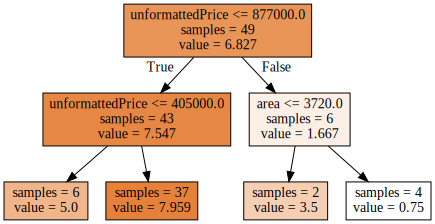

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz 
import graphviz


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor()
regr_1.fit(x.fillna(0), y)
regr_2.fit(x.fillna(0), y)
regr_3.fit(x.fillna(0), y)

export_graphviz(regr_1, out_file ='mytree1.dot',
               feature_names =list(x.columns), impurity=False, filled=True) 
with open('mytree1.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

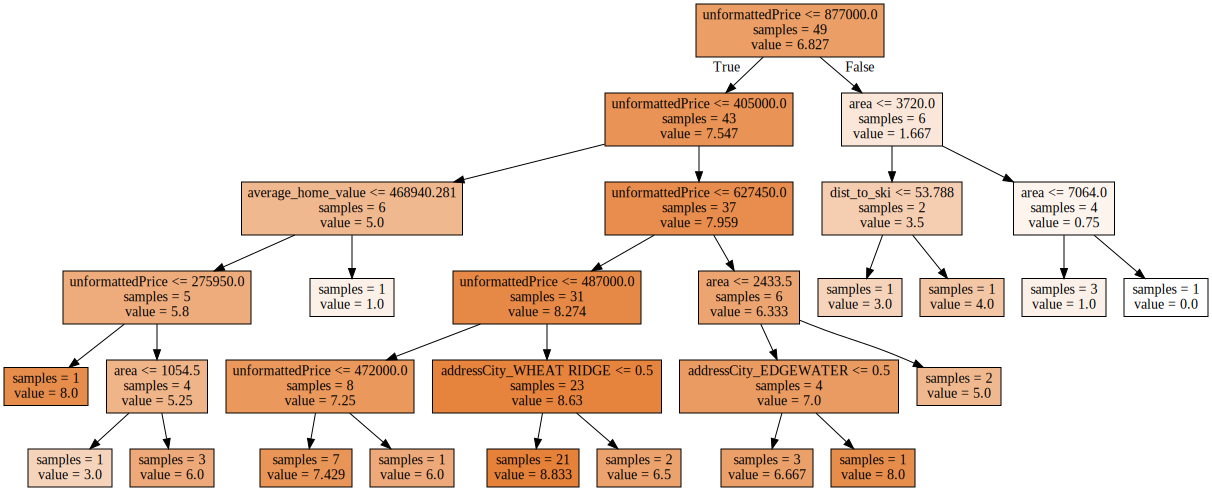

In [12]:
export_graphviz(regr_2, out_file ='mytree2.dot',
               feature_names =list(x.columns), impurity=False, filled=True) 
with open('mytree2.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

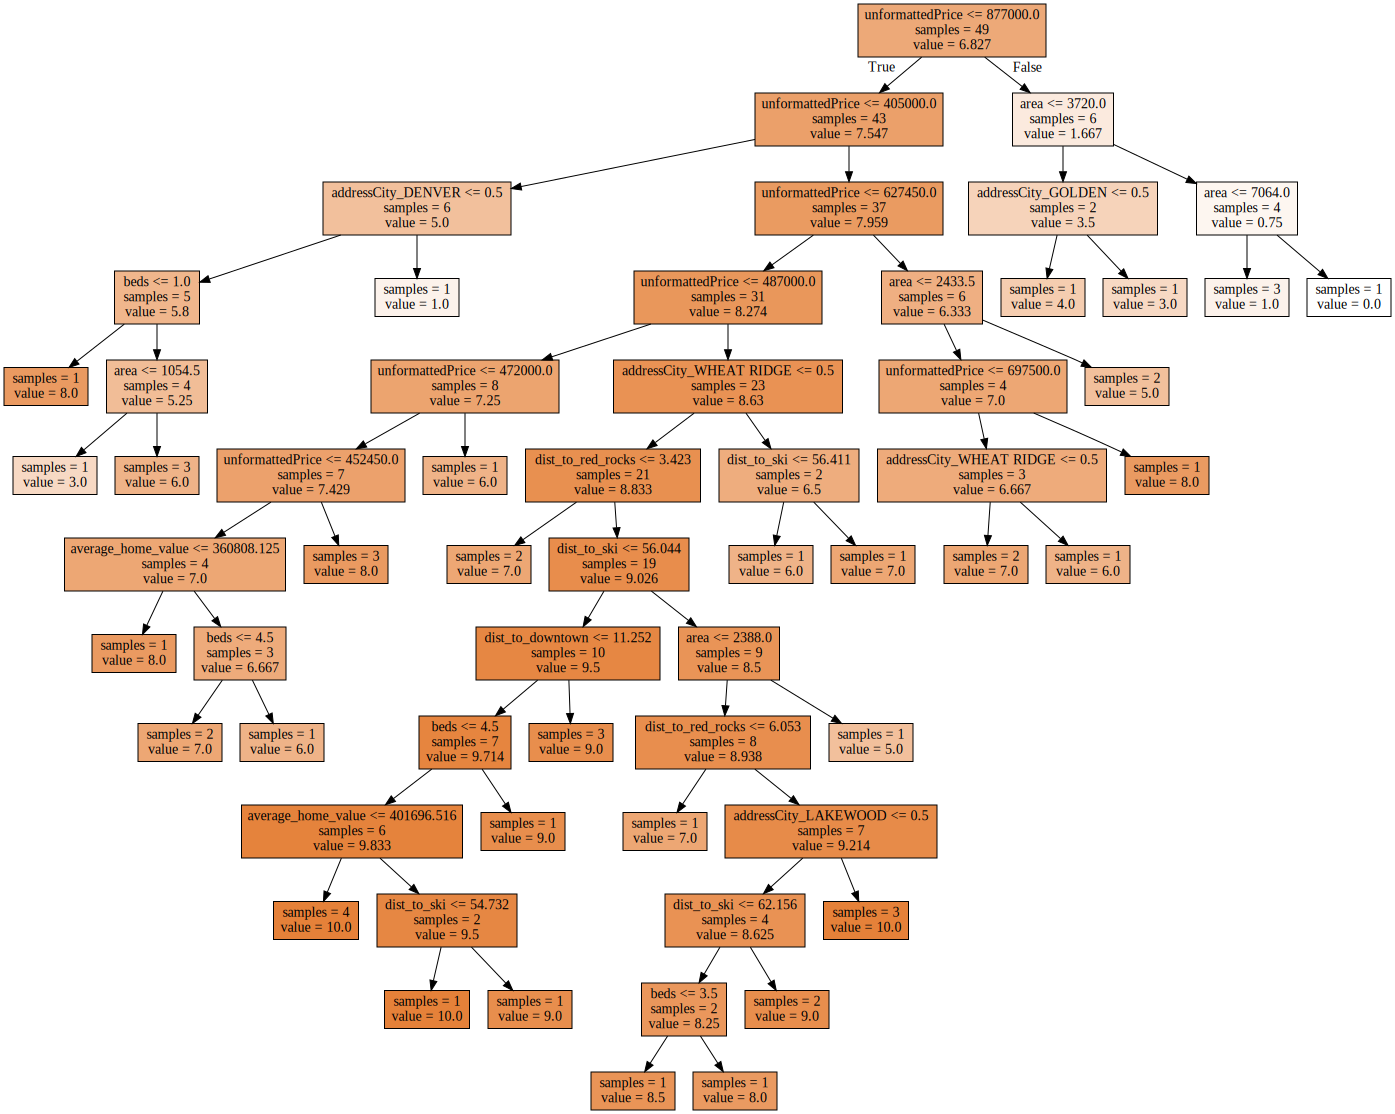

In [13]:
export_graphviz(regr_3, out_file ='mytree3.dot',
               feature_names =list(x.columns), impurity=False, filled=True) 
with open('mytree3.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [7]:
df = pd.read_sql_query(
    f'''
        SELECT *
        FROM denver_active_listings
    ''', cursor)

df.unformattedPrice = df.unformattedPrice.astype(float)
df.beds = df.beds.replace('null', 0).astype(int)
df.baths = df.baths.replace('null', 0).astype(float).astype(int)
df.area = df.area.replace('null', 0).astype(float)
df.addressCity = df.addressCity.astype("category")
df.dist_to_downtown = df.dist_to_downtown.astype(float)
df.dist_to_ski = df.dist_to_ski.astype(float)
df.dist_to_red_rocks = df.dist_to_red_rocks.astype(float)
df.edu_rank_score_2022 = df.edu_rank_score_2022.astype(float)
df.average_home_value = df.average_home_value.astype(float)

# y = df.rank_score
x = df[['unformattedPrice', 'beds', 'area', 'addressCity',
         'dist_to_downtown', 'dist_to_ski', 'dist_to_red_rocks',
         'edu_rank_score_2022', 'average_home_value']]
x = pd.get_dummies(x)
x = x[list(x.columns)]

In [8]:
x.describe()

,unformattedPrice,beds,area,dist_to_downtown,dist_to_ski,dist_to_red_rocks,edu_rank_score_2022,average_home_value,addressCity_ARVADA,addressCity_BROOMFIELD,addressCity_DENVER,addressCity_EDGEWATER,addressCity_GOLDEN,addressCity_LAKEWOOD,addressCity_LITTLETON,addressCity_MORRISON,addressCity_WESTMINSTER,addressCity_WHEAT RIDGE
count,5.420000e+02,542.000000,542.000000,542.000000,542.000000,542.000000,503.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000
mean,7.644224e+05,3.300738,2186.448339,8.419425,57.651737,9.220385,0.531285,404093.046285,0.116236,0.075646,0.154982,0.012915,0.051661,0.298893,0.075646,0.062731,0.071956,0.079336
std,9.686788e+05,1.266649,1172.722414,3.108542,3.795288,4.535572,0.096746,60874.751831,0.320804,0.264675,0.362221,0.113013,0.221545,0.458196,0.264675,0.242702,0.258653,0.270512
min,0.000000e+00,0.000000,0.000000,2.786747,50.615694,1.440603,0.284833,350892.028986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.999992e+05,2.000000,1468.750000,5.374186,54.792133,5.746170,0.578000,370724.221046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.219500e+05,3.000000,2044.000000,8.386224,56.844440,9.004310,0.578000,370724.221046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.642250e+05,4.000000,2611.500000,11.313652,61.963385,12.618577,0.578000,399680.189959,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.790000e+07,8.000000,9446.000000,14.039951,63.965634,19.563619,0.578000,538200.361898,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.tail(10)

,index,detailUrl,unformattedPrice,address,addressStreet,addressCity,addressZipcode,addressState,beds,baths,...,longitude,dist_to_downtown,dist_to_ski,dist_to_red_rocks,zip,county,edu_rank_score_2022,OWNER_CITY,average_home_value,date_stamp
532,532,www.zillow.com/homedetails/6797-Meade-Cir-West...,595000.0,6797 Meade Circle,6797 Meade Circle,WESTMINSTER,80030,CO,3,3,...,-105.03746,4.759749,62.063371,13.979569,80030,Adams County,0.284833,WESTMINSTER,350892.028986,2022-09-29
533,533,www.zillow.com/homedetails/6204-Xavier-Ct-Arva...,525000.0,6204 Xavier Court,6204 Xavier Court,ARVADA,80003,CO,3,2,...,-105.050354,4.764212,61.154935,12.978908,80003,Jefferson County,0.578000,ARVADA,399680.189959,2022-09-29
534,534,www.zillow.com/homedetails/6621-Julian-St-Denv...,520000.0,6621 Julian Street,6621 Julian Street,DENVER,80221,CO,5,2,...,-105.031395,4.390627,62.284419,14.033792,80221,Adams County,0.284833,DENVER,538200.361898,2022-09-29
535,535,www.zillow.com/homedetails/3980-W-66th-Ave-Arv...,699900.0,3980 W 66th Avenue,3980 W 66th Avenue,ARVADA,80003,CO,3,3,...,-105.03925,4.637648,61.880646,13.725755,80003,Jefferson County,0.578000,ARVADA,399680.189959,2022-09-29
536,536,www.zillow.com/homedetails/6631-Julian-St-Denv...,510000.0,6631 Julian Street,6631 Julian Street,DENVER,80221,CO,4,2,...,-105.03139,4.401414,62.289931,14.044540,80221,Adams County,0.284833,DENVER,538200.361898,2022-09-29
537,537,www.zillow.com/homedetails/7310-W-23rd-Ave-Lak...,774900.0,7310 W 23 Avenue,7310 W 23 Avenue,LAKEWOOD,80214,CO,3,3,...,-105.07808,5.420878,58.373000,9.045207,80214,Jefferson County,0.578000,LAKEWOOD,370724.221046,2022-09-29
538,538,www.zillow.com/homedetails/3100-Quay-St-Wheat-...,875000.0,3100 Quay Street,3100 Quay Street,WHEAT RIDGE,80033,CO,4,4,...,-105.07313,5.042101,58.864900,9.741393,80033,Jefferson County,0.578000,WHEAT RIDGE,399577.777778,2022-09-29
539,539,www.zillow.com/homedetails/7425-W-34th-Ave-Whe...,706900.0,7425 W 34th Avenue,7425 W 34th Avenue,WHEAT RIDGE,80033,CO,4,2,...,-105.07911,5.344405,58.643450,9.678032,80033,Jefferson County,0.578000,WHEAT RIDGE,399577.777778,2022-09-29
540,540,www.zillow.com/homedetails/2950-Otis-Ct-Wheat-...,676000.0,2950 Otis Court,2950 Otis Court,WHEAT RIDGE,80214,CO,4,2,...,-105.07089,4.938478,58.931143,9.733978,80214,Jefferson County,0.578000,WHEAT RIDGE,399577.777778,2022-09-29
541,125,www.zillow.com/homedetails/5273-S-Tabor-Way-Li...,700000.0,5273 S Tabor Way,5273 S Tabor Way,LITTLETON,80127,CO,3,3,...,-105.13168,12.999520,53.368246,5.072126,80127,Jefferson County,0.578000,LITTLETON,357191.166078,2022-09-29


In [10]:
predictions = rf.predict(x.fillna(0))

In [14]:
df['predictions'] = predictions

df = df[['address', 'predictions']]
df.to_sql("denver_prediction_values", cursor, if_exists="replace")
cursor.close()

In [ ]:
pd.set_option('display.max_rows', None)
df[(df.predictions > 8.5)]

In [14]:
cursor = sqlite3.connect("denver_real_estate.db")
test = pd.read_sql_query(
    f'''
        SELECT *
        FROM test_df
    ''', cursor).drop(columns=['level_0'])
# cursor.close()

In [ ]:
importances = list(rf.feature_importances_)
features = list(x.columns)

feature_importance = pd.DataFrame({'features':features, 'importances':importances})
feature_importance.sort_values('importances', ascending=False)

In [ ]:
df

In [15]:
pd.set_option('display.max_rows', 10)
test.iloc[[34]]

,index,detailUrl,unformattedPrice,address,addressStreet,addressCity,addressZipcode,addressState,beds,baths,...,dist_to_downtown,dist_to_ski,dist_to_red_rocks,zip,county,edu_rank_score_2022,OWNER_CITY,average_home_value,date_stamp,rank_score
34,466,www.zillow.com/homedetails/6695-W-25th-Ln-Edge...,700000.0,6695 W 25th Lane,6695 W 25th Lane,EDGEWATER,80214,CO,4,2,...,5.003316,58.808615,9.497969,80214,Jefferson County,0.578,EDGEWATER,428078.26087,2022-09-28,8.0


In [ ]:
new_df = df.iloc[[335]]
new_df['rank_score'] = 5
test=test.append(new_df).drop(columns=['predictions'])

In [ ]:
test.to_sql("test_df", cursor, if_exists="replace")

## What we have so far
#### Spider
Function to pull out 40 zillow listings based on geographic areas

#### URLs for Different Denver Geographic Areas
Spider walks through various URLs to grab different data points

#### Education Scores by County

#### Average Home Value by City

## What we need

#### Loudness Index?

#### Home Estimate Value

#### Model for Ranking Our Likelihood to Want to Buy

## Python Scripts/Function Needed

#### 1. Webscraping (E)

#### 2. Data Ingest and Load (TL)

#### 3. Modelling

#### 4. Logging

#### 5. CI/CD

## Additional Resources

#### 1. Dashboard

#### 2. UI to Database

#### 3. Airflow DAG running daily